In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from shap import TreeExplainer, summary_plot
import shap


c:\Users\amanu\OneDrive\Desktop\KIFIYA_10_ACADEMY\Insurance-Analytics\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append('../scripts')

In [17]:
# Import the modules
import data_processing as dp
import modeling as m


In [7]:
# Load the original .csv file
df = pd.read_csv('../data/MachineLearningRating_v3_cleaned.csv')
# Display the first few rows
df.head()

C:\Users\amanu\AppData\Local\Temp\ipykernel_10484\847205758.py:2: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/MachineLearningRating_v3_cleaned.csv')


,",UnderwrittenCoverID",PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,"0,145249",12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,.000000000000
1,"1,145249",12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,.000000000000
2,"2,145249",12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,.000000000000
3,"3,145255",12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,.000000000000
4,"4,145255",12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,.000000000000


In [5]:
# Check for missing values
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
print("Missing Data Summary:")
print(pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage}))


Missing Data Summary:
                          Missing Values  Percentage
,UnderwrittenCoverID                   0         0.0
PolicyID                               0         0.0
TransactionMonth                       0         0.0
IsVATRegistered                        0         0.0
Citizenship                            0         0.0
LegalType                              0         0.0
Title                                  0         0.0
Language                               0         0.0
Bank                                   0         0.0
AccountType                            0         0.0
MaritalStatus                          0         0.0
Gender                                 0         0.0
Country                                0         0.0
Province                               0         0.0
PostalCode                             0         0.0
MainCrestaZone                         0         0.0
SubCrestaZone                          0         0.0
ItemType                

In [5]:
def encoder(method, dataframe, columns_label, columns_onehot):
    if method == 'labelEncoder':      
        df_lbl = dataframe.copy()
        for col in columns_label:
            label = LabelEncoder()
            label.fit(list(dataframe[col].values))
            df_lbl[col] = label.transform(df_lbl[col].values)
        return df_lbl
    
    elif method == 'oneHotEncoder':
        df_oh = dataframe.copy()
        df_oh= pd.get_dummies(data=df_oh, prefix='ohe', prefix_sep='_',
                       columns=columns_onehot, drop_first=True, dtype='int8')
        return df_oh

def scaler(method, data, columns_scaler):    
    if method == 'standardScaler':        
        Standard = StandardScaler()
        df_standard = data.copy()
        df_standard[columns_scaler] = Standard.fit_transform(df_standard[columns_scaler])        
        return df_standard
        
    elif method == 'minMaxScaler':        
        MinMax = MinMaxScaler()
        df_minmax = data.copy()
        df_minmax[columns_scaler] = MinMax.fit_transform(df_minmax[columns_scaler])        
        return df_minmax
    
    elif method == 'npLog':        
        df_nplog = data.copy()
        df_nplog[columns_scaler] = np.log(df_nplog[columns_scaler])        
        return df_nplog
    
    return data


In [8]:
# Columns to apply label encoding and one-hot encoding
columns_label = ['Gender', 'Province', 'PostalCode']
columns_onehot = ['MaritalStatus', 'VehicleType', 'CoverType']

# Apply Label Encoding
df_label =encoder('labelEncoder', df, columns_label, columns_onehot)

In [9]:
df_label

,",UnderwrittenCoverID",PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,"0,145249",12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,.000000000000
1,"1,145249",12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,.000000000000
2,"2,145249",12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,.000000000000
3,"3,145255",12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,.000000000000
4,"4,145255",12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,.000000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000093,"1000093,31520",389,2015-04-01 00:00:00,False,ZW,Individual,Mr,English,ABSA Bank,Savings account,...,No excess,Third Party,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,347.235175,0.0
1000094,"1000094,31520",389,2015-06-01 00:00:00,False,ZW,Individual,Mr,English,ABSA Bank,Savings account,...,No excess,Third Party,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,347.235175,0.0
1000095,"1000095,31520",389,2015-08-01 00:00:00,False,ZW,Individual,Mr,English,ABSA Bank,Savings account,...,No excess,Third Party,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,347.235175,0.0
1000096,"1000096,31519",389,2014-07-01 00:00:00,False,ZW,Individual,Mr,English,ABSA Bank,Savings account,...,No excess,Passenger Liability,Passenger Liability,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,2.315000,0.0


In [11]:
# List of columns you want to select
columns_to_select = ['Gender', 'Province', 'PostalCode', 'TotalPremium']

# Select the columns from the DataFrame
df_selected = df[columns_to_select]

# Display the first few rows of the selected columns
print(df_selected.head())


          Gender Province  PostalCode  TotalPremium
0  Not specified  Gauteng        1459     21.929825
1  Not specified  Gauteng        1459     21.929825
2  Not specified  Gauteng        1459      0.000000
3  Not specified  Gauteng        1459    512.848070
4  Not specified  Gauteng        1459      0.000000


In [12]:
# Columns to apply label encoding and one-hot encoding
columns_label = ['Gender', 'Province', 'PostalCode']
columns_onehot = ['MaritalStatus', 'VehicleType', 'CoverType']

# Apply Label Encoding
df_label =encoder('labelEncoder', df_selected, columns_label, columns_onehot)

In [13]:
df_label

,Gender,Province,PostalCode,TotalPremium
0,2,2,261,21.929825
1,2,2,261,21.929825
2,2,2,261,0.000000
3,2,2,261,512.848070
4,2,2,261,0.000000
...,...,...,...,...
1000093,1,8,773,347.235175
1000094,1,8,773,347.235175
1000095,1,8,773,347.235175
1000096,1,8,773,2.315000


In [15]:
columns_scaler = ['TotalPremium']
df_scaled = scaler('MinMaxScaler', df_label, columns_scaler)
df_scaled

,Gender,Province,PostalCode,TotalPremium
0,2,2,261,21.929825
1,2,2,261,21.929825
2,2,2,261,0.000000
3,2,2,261,512.848070
4,2,2,261,0.000000
...,...,...,...,...
1000093,1,8,773,347.235175
1000094,1,8,773,347.235175
1000095,1,8,773,347.235175
1000096,1,8,773,2.315000


In [18]:
# Split the data
X = df_scaled.drop('TotalPremium', axis=1)
y = df_scaled['TotalPremium']
X_train, X_test, y_train, y_test = m.split_data(X, y)

In [19]:
X_train

,Gender,Province,PostalCode
448476,2,8,765
629423,2,2,246
293724,2,2,28
793115,2,6,140
120459,2,2,381
...,...,...,...
259178,2,2,309
365838,2,6,113
131932,2,2,281
671155,2,8,811


In [20]:
# Train models
lr_model, dt_model, rfr_model, xgb_model = m.train_models(X_train, y_train)

In [21]:

# Evaluate models
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
mae_scores, mse_scores, r2_scores = [], [], []
for model in [lr_model, dt_model, rfr_model, xgb_model]:
    mae, mse, r2, _ = m.evaluate_model(model, X_test, y_test)
    mae_scores.append(mae)
    mse_scores.append(mse)
    r2_scores.append(r2)


# Display the evaluation results for each model
for i, model_name in enumerate(models):
    print(f"Evaluation results for {model_name}:")
    print(f"  - Mean Absolute Error (MAE): {mae_scores[i]}")
    print(f"  - Mean Squared Error (MSE): {mse_scores[i]}")
    print(f"  - R-squared (R2) Score: {r2_scores[i]}")
    print("\n")  # Adds a newline for readability between models


Evaluation results for Linear Regression:
  - Mean Absolute Error (MAE): 90.67833305176114
  - Mean Squared Error (MSE): 27525.93764020582
  - R-squared (R2) Score: 0.0022561112140238038


Evaluation results for Decision Tree:
  - Mean Absolute Error (MAE): 89.36609523473705
  - Mean Squared Error (MSE): 27163.539332265696
  - R-squared (R2) Score: 0.015392110495134337


Evaluation results for Random Forest:
  - Mean Absolute Error (MAE): 89.34122300254718
  - Mean Squared Error (MSE): 27161.44831347521
  - R-squared (R2) Score: 0.015467904506107244


Evaluation results for XGBoost:
  - Mean Absolute Error (MAE): 90.04269894187902
  - Mean Squared Error (MSE): 27316.433960063856
  - R-squared (R2) Score: 0.009850076559440146




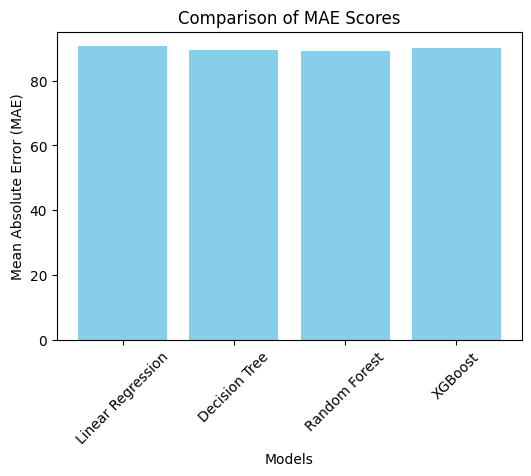

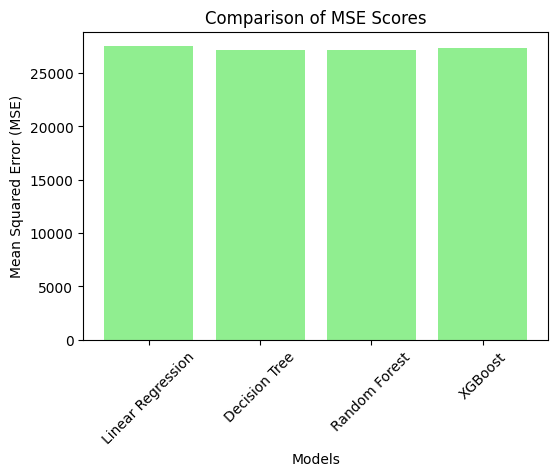

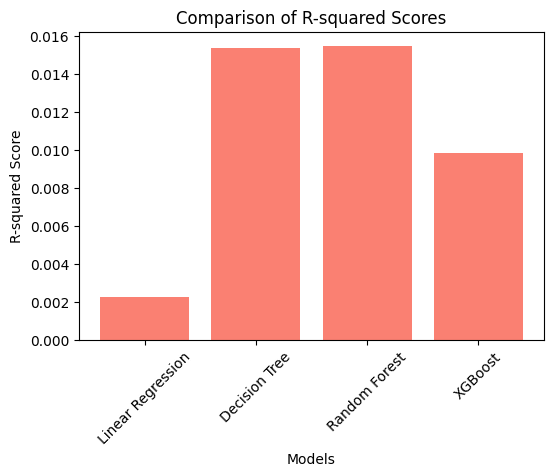

In [22]:
# Plot metrics
m.plot_metrics(models, mae_scores, mse_scores, r2_scores)

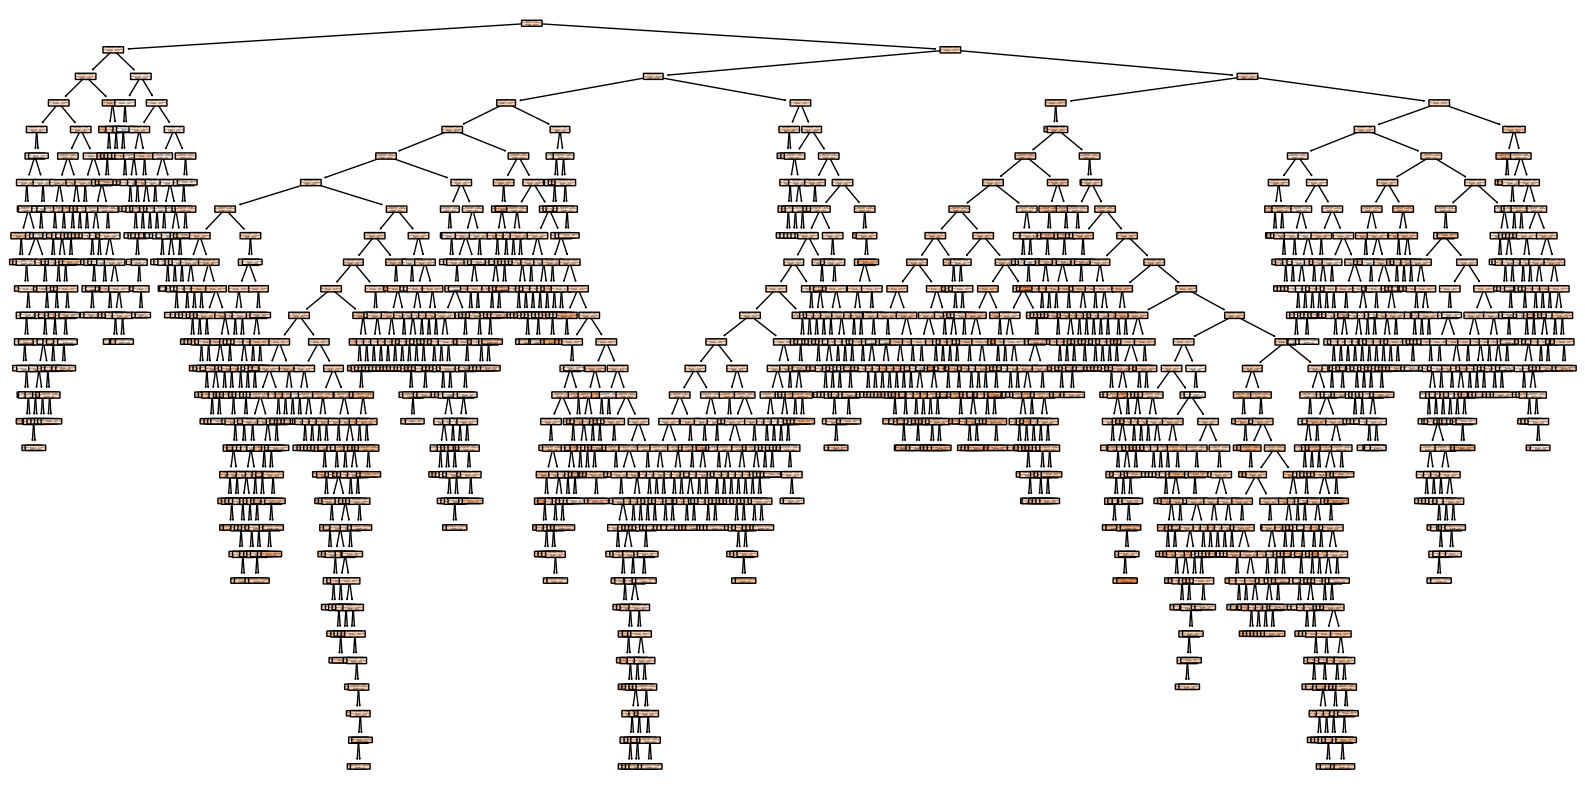

In [23]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
# Extract a single decision tree from the Random Forest
tree_index = 0  # Choose the index of the tree you want to visualize
#single_tree = dt_model.estimators_[tree_index]

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(decision_tree= dt_model, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

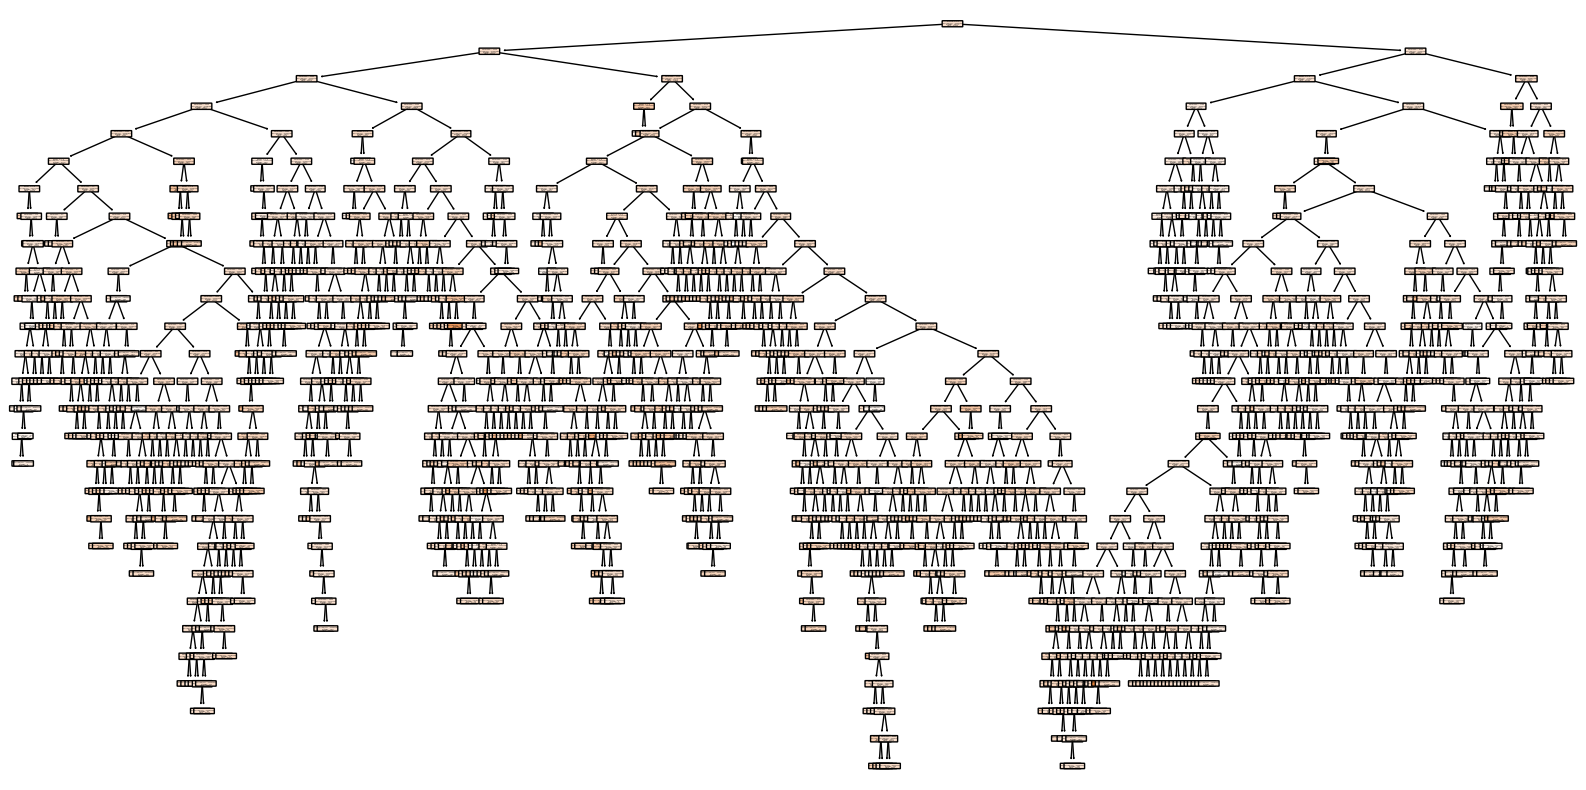

In [24]:
# Extract a single decision tree from the Random Forest
tree_index = 0  # Choose the index of the tree you want to visualize
single_tree = rfr_model.estimators_[tree_index]

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(single_tree, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

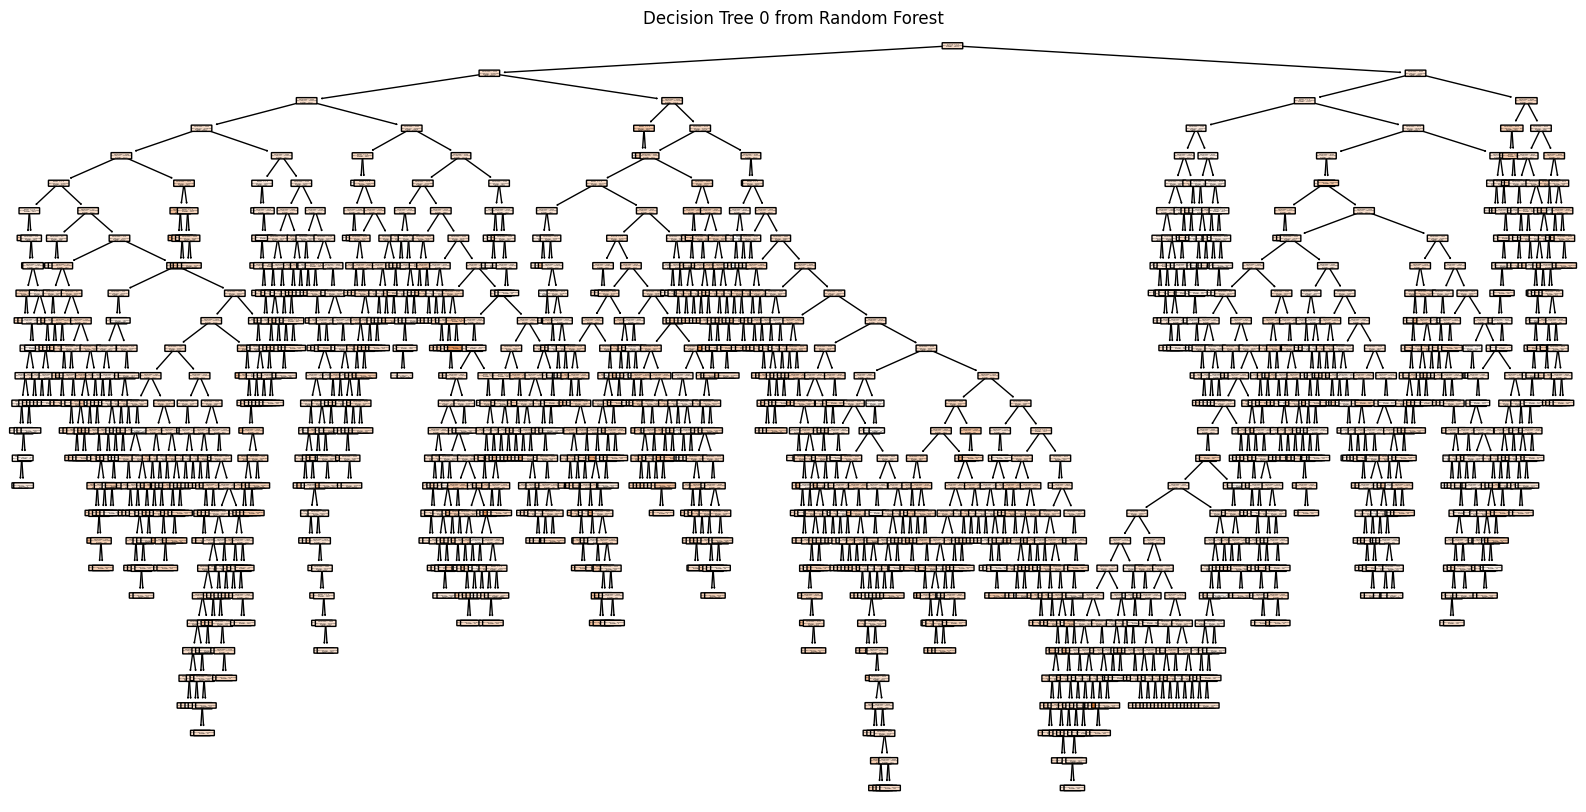

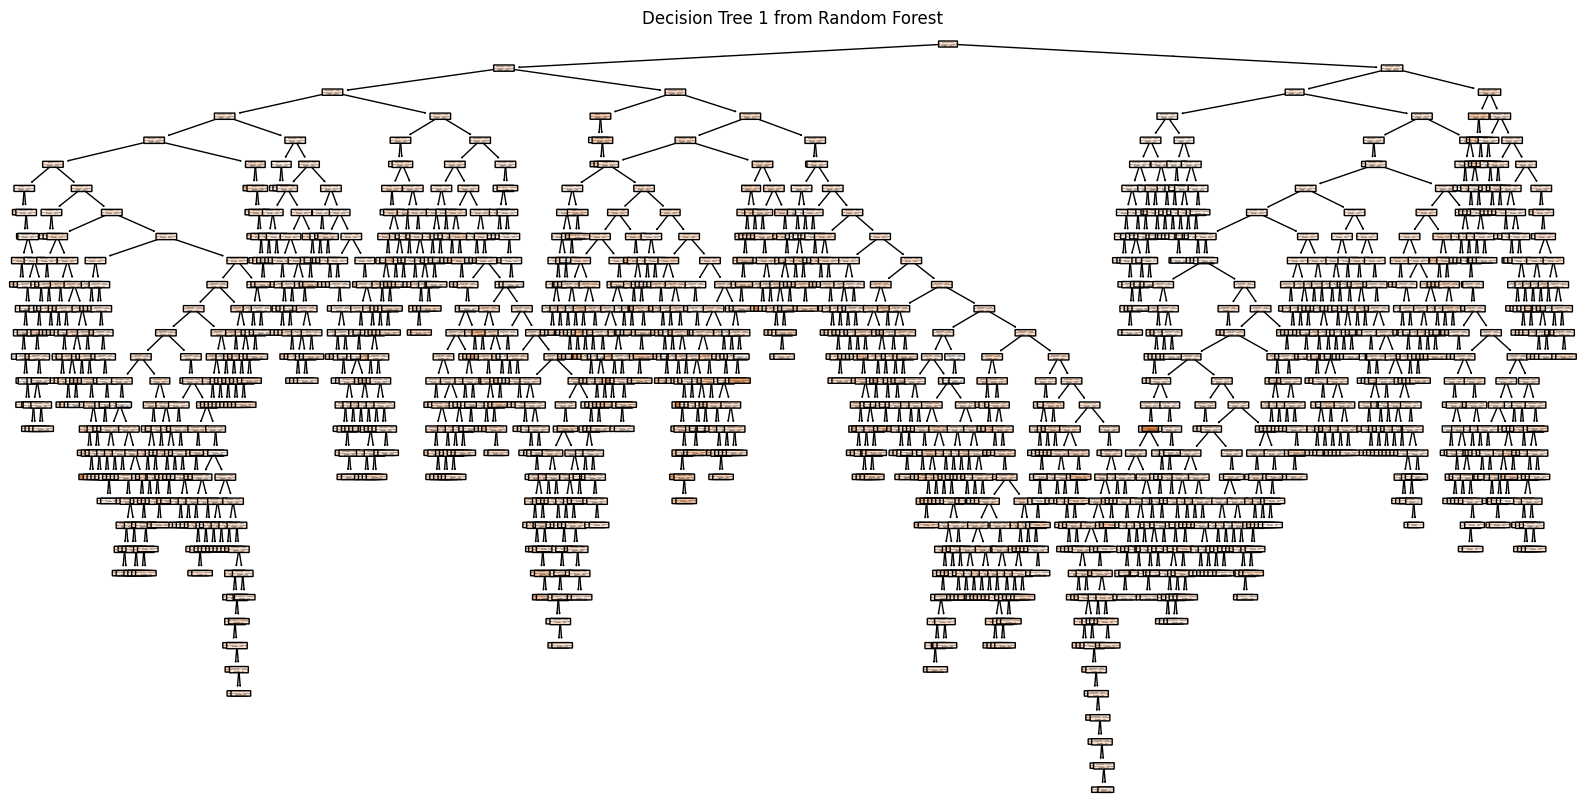

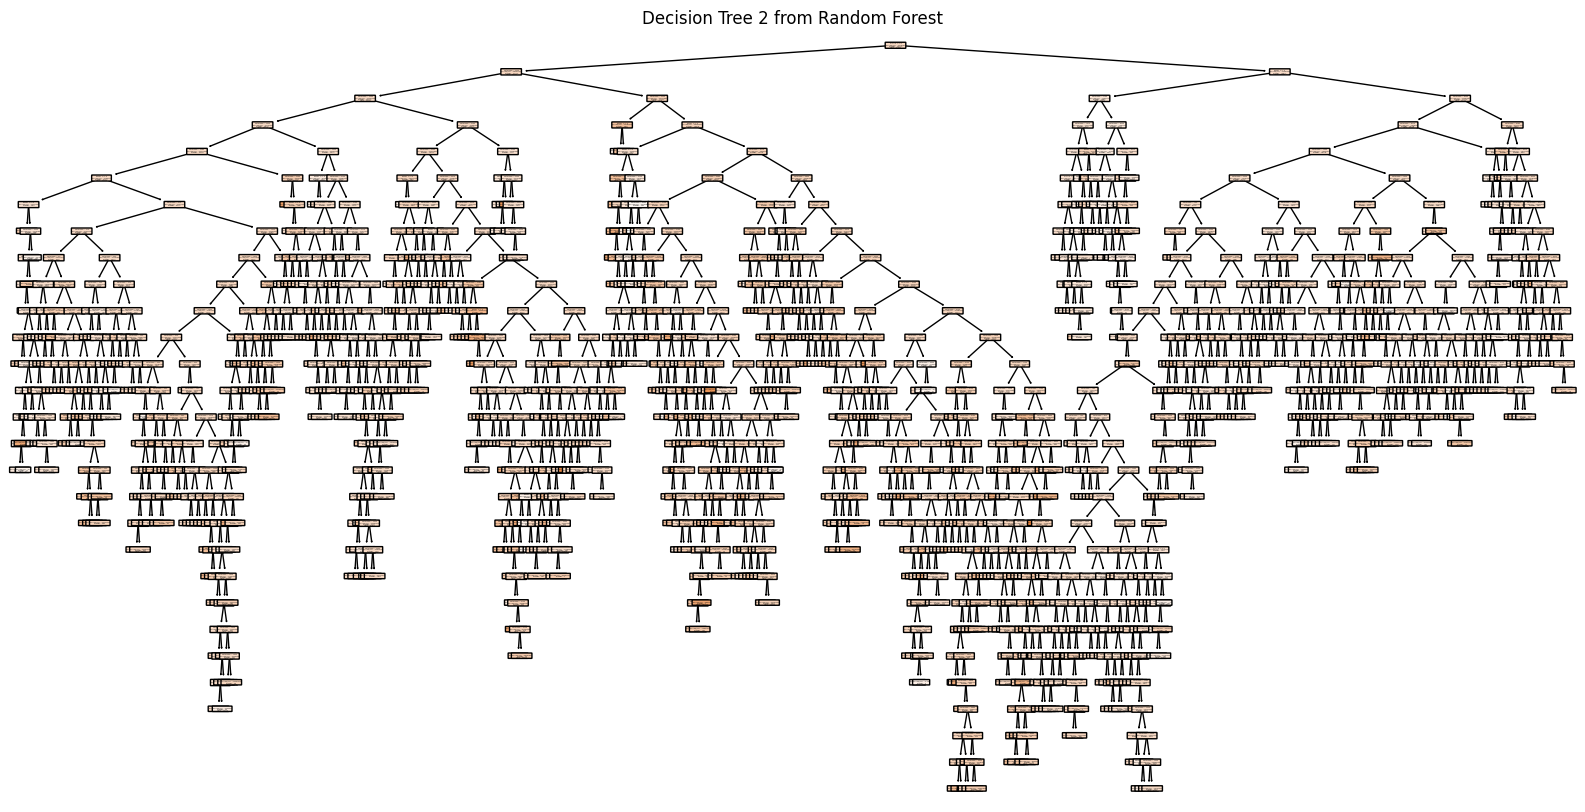

In [25]:
# Plot multiple trees from the Random Forest
for tree_index in range(3):  # Plot the first 3 trees
    single_tree = rfr_model.estimators_[tree_index]
    plt.figure(figsize=(20, 10))
    plot_tree(single_tree, feature_names=X_train.columns, filled=True, rounded=True)
    plt.title(f"Decision Tree {tree_index} from Random Forest")
    plt.show()


<Figure size 1000x600 with 0 Axes>

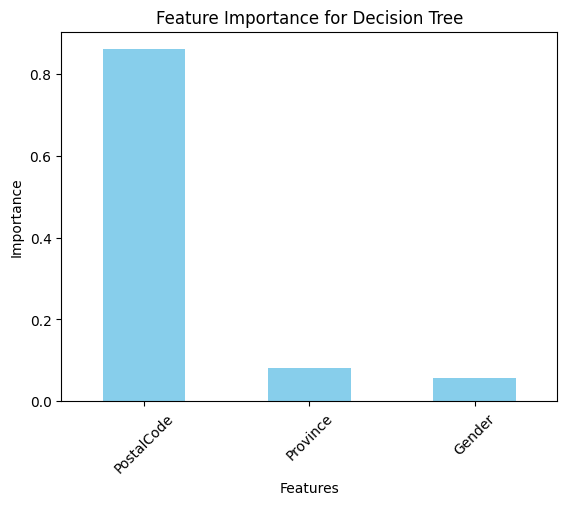

<Figure size 1000x600 with 0 Axes>

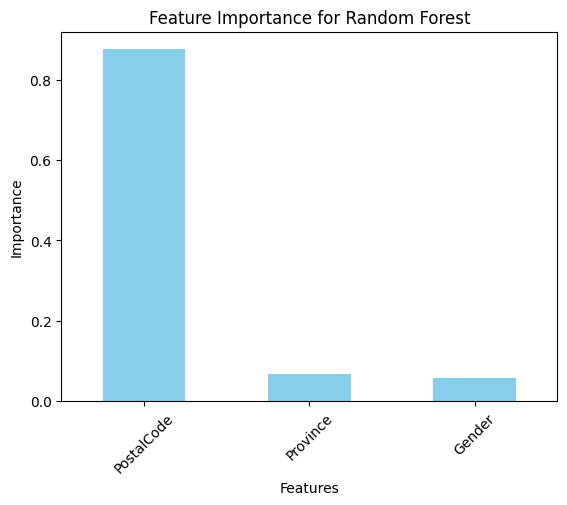

<Figure size 1000x600 with 0 Axes>

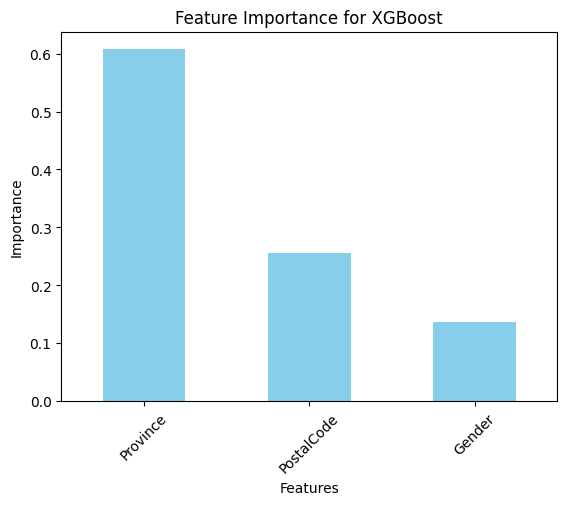

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to plot feature importance
def plot_feature_importance(model, feature_names, model_name):
    # Get feature importance
    feature_importance = pd.DataFrame(model.feature_importances_, index=feature_names, columns=["Importance"])
    feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    feature_importance.plot(kind='bar', legend=False, color='skyblue')
    plt.title(f'Feature Importance for {model_name}')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    plt.show()

# Call the function for each model
plot_feature_importance(dt_model, X_train.columns, "Decision Tree")
plot_feature_importance(rfr_model, X_train.columns, "Random Forest")
plot_feature_importance(xgb_model, X_train.columns, "XGBoost")
